## Regression Project

Build a linear regression model that predicts the `price` column in the dataset on San Francisco Apartment rentals. Make sure to go through all the the relevant steps of the modelling workflow.

1. Data Cleaning has already been performed on this data
2. Explore the data, keeping an eye on useful features and potential 
3. Choose a model validation scheme (simple or cross validation)
4. Fit a Linear Regression Model
5. Evaluate your model - check assumptions, metrics, and coefficient estimates
6. Engineer Features as needed
7. Repeat Steps 2, 4, 5, 6 as needed
8. Once you are ready, fit your final model and report final model performance estimate by scoring on the test data. Report both test R-squared and MAE.

A reasonable goal is to get a validation MAE of <= 500 dollars.

Advice:

1. "Perfect" is the enemy of "Good".
2. You will not get to an MAE of 0, we don't have perfect data, and there is some randomness and emotion in how things like apartment prices are set.
3. Modelling is challenging, especially if you're new. There isn't a "right" answer, but some models are better than others. Remember - "All Models are wrong, but some are useful" 
4. We will likely end up with different models and performance metrics, and that's ok. You can always implement new ideas after watching the solution video. I didn't do anything too fancy, so you might think of some great ideas I didn't!
5. Enjoy the process, and remember that at some point it's time to let the model go. No amount of feature engineering will achieve a perfect model.

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score as r2, mean_absolute_error as mae, mean_squared_error as mse

rentals_df = pd.read_csv("Data/sf_clean.csv")#.query("price <= 6000")


rentals_df.head()

,price,sqft,beds,bath,laundry,pets,housing_type,parking,hood_district
0,6800,1600.0,2.0,2.0,(a) in-unit,(d) no pets,(c) multi,(b) protected,7.0
1,3500,550.0,1.0,1.0,(a) in-unit,(a) both,(c) multi,(b) protected,7.0
2,5100,1300.0,2.0,1.0,(a) in-unit,(a) both,(c) multi,(d) no parking,7.0
3,9000,3500.0,3.0,2.5,(a) in-unit,(d) no pets,(c) multi,(b) protected,7.0
4,3100,561.0,1.0,1.0,(c) no laundry,(a) both,(c) multi,(d) no parking,7.0


### Data Dictionary

1. Price: The price of the rental and our target variable
2. sqft: The area in square feet of the rental
3. beds: The number of bedrooms in the rental
4. bath: The number of bathrooms in the rental
5. laundry: Does the rental have a laundry machine inside the house, a shared laundry machine, or no laundry on site?
6. pets: Does the rental allow pets? Cats only, dogs only or both cats and dogs?
7. Housing type: Is the rental in a multi-unit building, a building with two units, or a stand alone house? 
8. Parking: Does the apartment off a parking space? No, protected in a garage, off-street in a parking lot, or valet service?
9. Hood district: Which part of San Francisco is the apartment located?

![image info](SFAR_map.png)

In [2]:
rentals_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 989 entries, 0 to 988
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          989 non-null    int64  
 1   sqft           989 non-null    float64
 2   beds           989 non-null    float64
 3   bath           989 non-null    float64
 4   laundry        989 non-null    object 
 5   pets           989 non-null    object 
 6   housing_type   989 non-null    object 
 7   parking        989 non-null    object 
 8   hood_district  989 non-null    float64
dtypes: float64(4), int64(1), object(4)
memory usage: 69.7+ KB


## EDA

1. Based on the range of prices below, we may need to subset our data based on some value to predict more "realistic" apartments. Possibly subset based on square-footage.

2. The 'hood_district' feature was read in as an integer but is really a categorical feature. Let's fix that.


In [3]:
rentals_df["hood_district"] = rentals_df["hood_district"].astype("object") 

In [4]:
rentals_df.describe()

,price,sqft,beds,bath
count,989.000000,989.000000,989.000000,989.000000
mean,3595.035389,976.765420,1.679474,1.390293
std,1546.222670,474.629798,1.076710,0.562714
min,750.000000,150.000000,0.000000,1.000000
25%,2650.000000,650.000000,1.000000,1.000000
50%,3300.000000,900.000000,2.000000,1.000000
75%,4242.000000,1200.000000,2.000000,2.000000
max,19000.000000,3500.000000,6.000000,4.000000


There are some very rare, expensive apartments that cost over 10k.

<Axes: xlabel='price', ylabel='Count'>

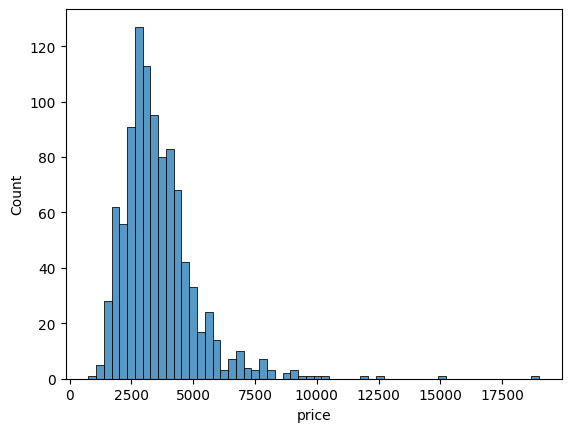

In [5]:
sns.histplot(rentals_df, x="price")

Most of our numeric features are positively correlated with each other, could cause problems.

It's good to see that we have some strong correlations with our target here though.

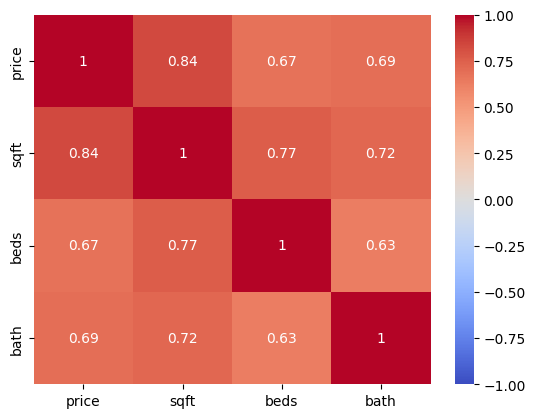

In [6]:
sns.heatmap(
    rentals_df.corr(numeric_only=True), 
    vmin=-1, 
    vmax=1, 
    cmap="coolwarm",
    annot=True
);

Based on the pairplot below, we may be able to slice off the most expensive aparments by subsetting to only aparments <2500 sqft. 

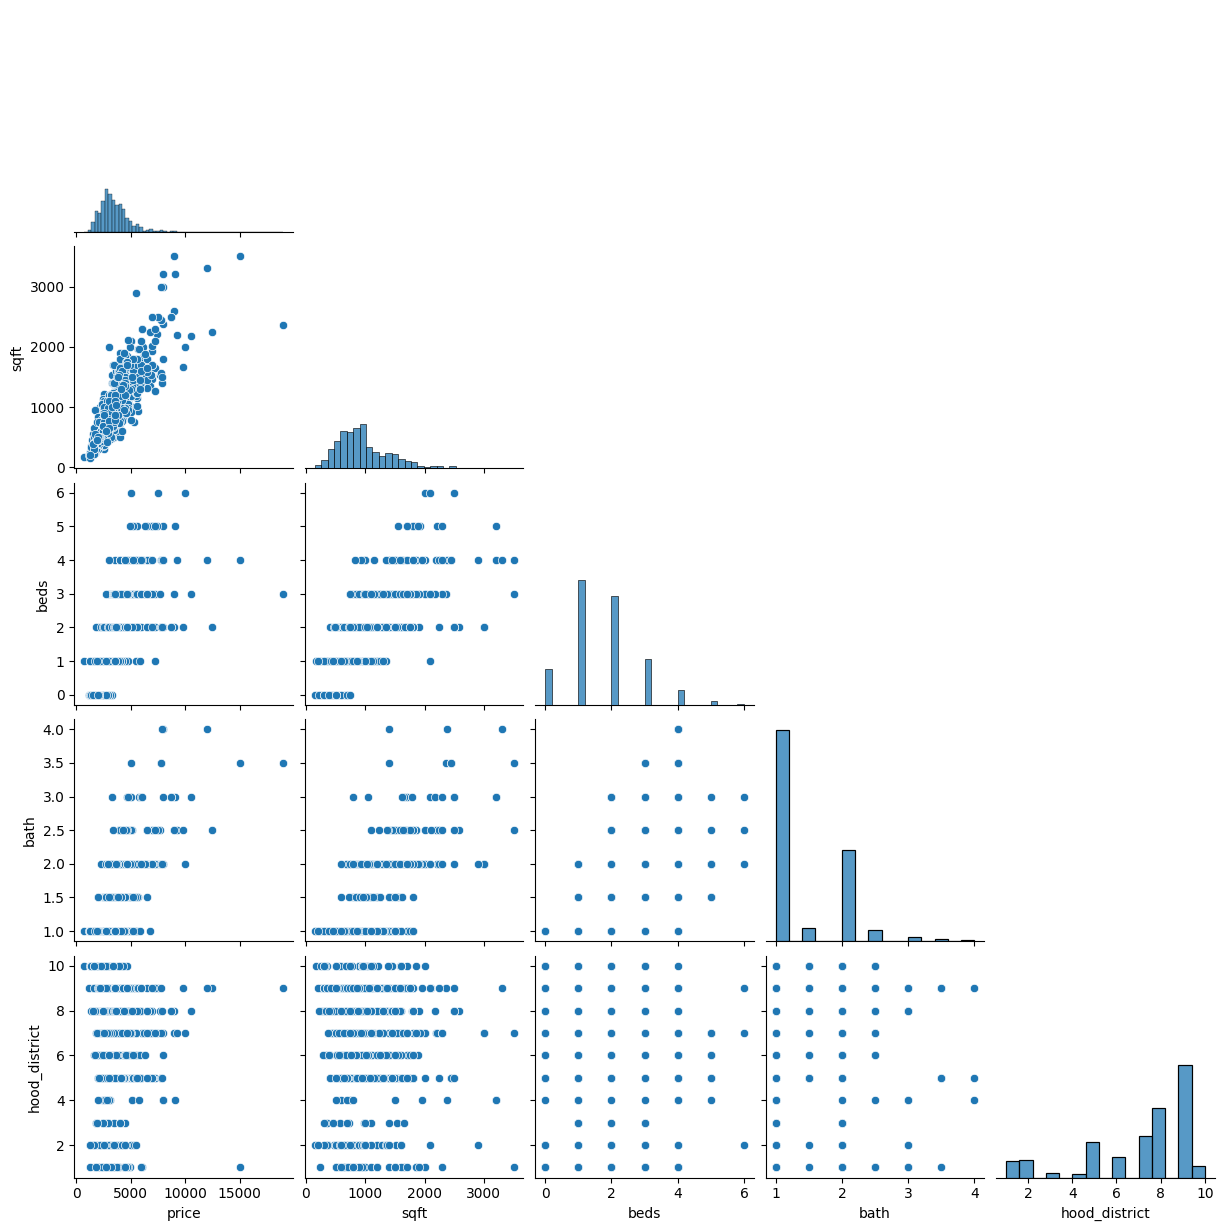

In [7]:
sns.pairplot(rentals_df, 
             corner=True
            )

Moving on to our categorical features, we have some rare categories that may need to be binned together.

We should consider:

1. Pets: Bin 'dogs', and 'both' into a 'dogs' 'allows_dogs' category.
2. Housing_type: Group 'multi' and 'double' together
3. Parking: Group 'protected', 'off-street', and 'valet' together
4. We should bin some of our lower count neighbhoords with neighboring ones. Let's look at average pricing for each and see which are related based on price.

In [8]:
# Let's check the frequency of our categorical features

def value_counter(dataframe):
    value_series = pd.DataFrame()
    for col in dataframe.select_dtypes(["object"]).columns:
        print(dataframe[col].value_counts())
        
        
value_counter(rentals_df)

laundry
(a) in-unit       488
(b) on-site       370
(c) no laundry    131
Name: count, dtype: int64
pets
(d) no pets    510
(a) both       367
(c) cats        91
(b) dogs        21
Name: count, dtype: int64
housing_type
(c) multi     937
(a) single     40
(b) double     12
Name: count, dtype: int64
parking
(d) no parking    478
(b) protected     439
(c) off-street     38
(a) valet          34
Name: count, dtype: int64
hood_district
9.0     332
8.0     207
7.0     123
5.0     106
6.0      62
2.0      51
1.0      50
10.0     33
3.0      14
4.0      11
Name: count, dtype: int64


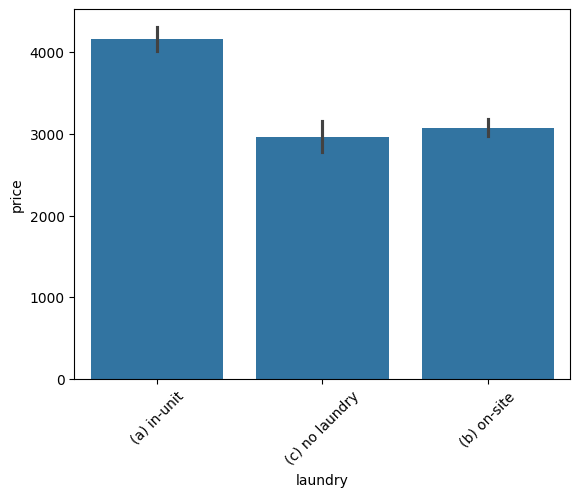

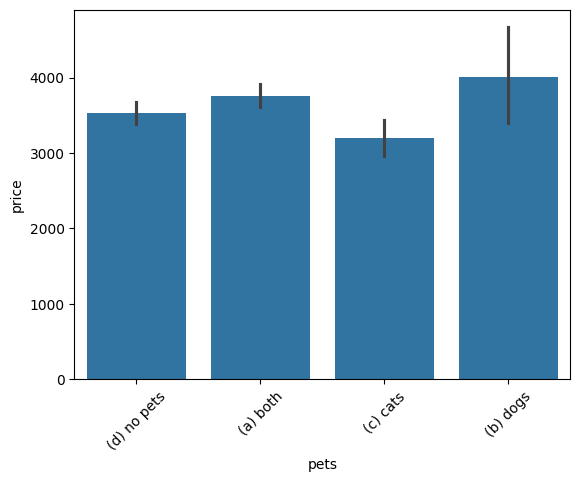

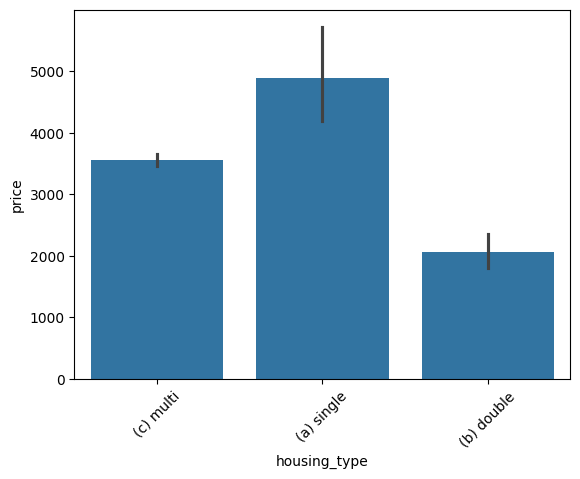

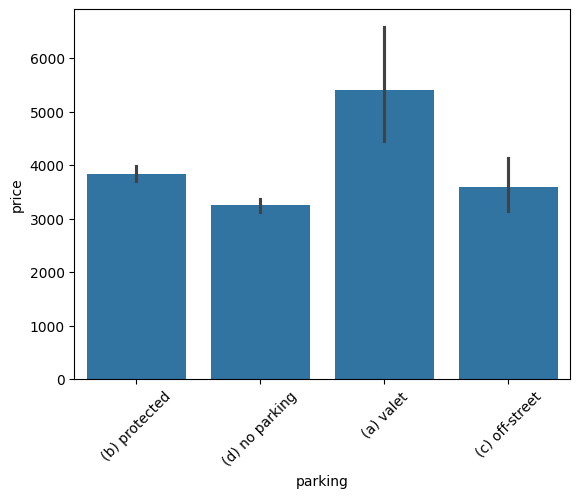

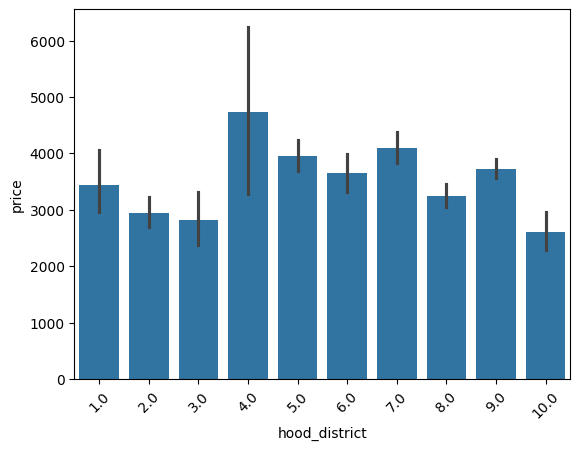

In [9]:
def cat_plotter(data, target):
    for col in data.select_dtypes(["object"]).columns:
        sns.barplot(data=data, x=col, y=target)
        plt.xticks(rotation=45)
        plt.show()
        
cat_plotter(rentals_df, "price")

In [10]:
!git add regression_modelling_project.ipynb
!git commit -m "EDA-5"
!git push origin master

On branch master
Your branch is up to date with 'origin/master'.

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	.ipynb_checkpoints/
	SFAR_map.png
	regression_modelling_project-1.ipynb

nothing added to commit but untracked files present (use "git add" to track)
Everything up-to-date


# Feature Engineering

1. Group Categories together
2. Trying a Squared Term for Bedrooms, sqft, and bath

In [11]:
laundry_map = {
    "(a) in-unit": "in_unit",
    "(b) on-site": "not_in_unit",
    "(c) no laundry": "not_in_unit",
}

pet_map = {
    "(a) both": "allows_dogs",
    "(b) dogs": "allows_dogs",
    "(c) cats": "no_dogs",
    "(d) no pets": "no_dogs"
}


housing_type_map = {
    "(a) single": "single",
    "(b) double": "multi",
    "(c) multi": "multi",
}

district_map = {
    1.0: "west",
    2.0: "southwest",
    3.0: "southwest",
    4.0: "central",
    5.0: "central",
    6.0: "central",
    7.0: "marina",
    8.0: "north beach",
    9.0: "FiDi/SOMA",
    10.0: "southwest"
    
}

In [72]:
eng_df = rentals_df.assign(
    hood_district = rentals_df["hood_district"].map(district_map),
    housing_type = rentals_df["housing_type"].map(housing_type_map),
    pets = rentals_df["pets"].map(pet_map),
    laundry = rentals_df["laundry"].map(laundry_map),
    sqft2 = rentals_df["sqft"] ** 2,
#     sqft3 = rentals_df["sqft"] ** 3,
#     beds2 = rentals_df["beds"] ** 2,
#     beds3 = rentals_df["beds"] ** 3,
#     bath2 = rentals_df["bath"] ** 2,
#     bath3 = rentals_df["bath"] ** 3,
    beds_bath_ratio = rentals_df["beds"] / rentals_df["bath"]
)

eng_df = pd.get_dummies(eng_df, drop_first=True).astype(int)

In [73]:
eng_df.head()

,price,sqft,beds,bath,sqft2,beds_bath_ratio,laundry_not_in_unit,pets_no_dogs,housing_type_single,parking_(b) protected,parking_(c) off-street,parking_(d) no parking,hood_district_central,hood_district_marina,hood_district_north beach,hood_district_southwest,hood_district_west
0,6800,1600,2,2,2560000,1,0,1,0,1,0,0,0,1,0,0,0
1,3500,550,1,1,302500,1,0,0,0,1,0,0,0,1,0,0,0
2,5100,1300,2,1,1690000,2,0,0,0,0,0,1,0,1,0,0,0
3,9000,3500,3,2,12250000,1,0,1,0,1,0,0,0,1,0,0,0
4,3100,561,1,1,314721,1,1,0,0,0,0,1,0,1,0,0,0


In [74]:
from sklearn.model_selection import train_test_split

target = "price"
# drop_cols = [
#     "pets_no_dogs",
#     "housing_type_single",
#     "beds_bath_ratio"
# ]

X = sm.add_constant(eng_df.drop([target], axis=1))

# Log transform slightly improves normality
y = np.log(eng_df[target])
# y = eng_df[target]

# Test Split
X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=2023)

In [75]:
def cross_val(X, y, n_splits):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=2023)
    # Create a list to store validation scores for each fold

    cv_lm_tr_r2s = []
    cv_lm_tr_mae = []
    cv_lm_val_r2s = []
    cv_lm_val_mae = []
    
    for train_ind, val_ind in kf.split(X, y):
        # Subset data based on CV folds
        X_train, y_train = X.iloc[train_ind], y.iloc[train_ind]
        X_val, y_val = X.iloc[val_ind], y.iloc[val_ind]
        # Fit the Model on fold's training data
        model = sm.OLS(y_train, X_train).fit()
        # Append Validation score to list 
        cv_lm_tr_r2s.append(r2(y_train, model.predict(X_train)))
        cv_lm_tr_mae.append(mae(y_train, model.predict(X_train)))
        cv_lm_val_r2s.append(r2(y_val, model.predict(X_val),))
        cv_lm_val_mae.append(mae(y_val, model.predict(X_val),))
        
        
    print(f"All Training R2s: {[round(x, 3) for x in cv_lm_tr_r2s]}")
    print(f"Training R2s: {round(np.mean(cv_lm_tr_r2s), 3)} +- {round(np.std(cv_lm_tr_r2s), 3)}")
    
    print(f"Training MAEs: {[round(x, 3) for x in cv_lm_tr_mae]}")
    print(f"Training MAEs: {round(np.mean(cv_lm_tr_mae), 3)} +- {round(np.std(cv_lm_tr_mae), 3)}")    
        
    print(f"All Validation R2s: {[round(x, 3) for x in cv_lm_val_r2s]}")
    print(f"Cross Val R2s: {round(np.mean(cv_lm_val_r2s), 3)} +- {round(np.std(cv_lm_val_r2s), 3)}")

    print(f"All Validation MAEs: {[round(x, 3) for x in cv_lm_val_mae]}")
    print(f"Cross Val MAEs: {round(np.mean(cv_lm_val_mae), 3)} +- {round(np.std(cv_lm_val_mae), 3)}")
    
    return model
    
model = cross_val(X, y, 5)

All Training R2s: [0.826, 0.829, 0.819, 0.83, 0.823]
Training R2s: 0.825 +- 0.004
Training MAEs: [0.122, 0.126, 0.125, 0.123, 0.126]
Training MAEs: 0.125 +- 0.002
All Validation R2s: [0.814, 0.799, 0.833, 0.794, 0.824]
Cross Val R2s: 0.813 +- 0.015
All Validation MAEs: [0.138, 0.125, 0.124, 0.133, 0.121]
Cross Val MAEs: 0.128 +- 0.006


In [76]:
# Model p-values: a few features have > .05

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.823
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                     178.5
Date:                Thu, 13 Nov 2025   Prob (F-statistic):          6.71e-219
Time:                        11:56:36   Log-Likelihood:                 246.49
No. Observations:                 633   AIC:                            -459.0
Df Residuals:                     616   BIC:                            -383.3
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         7.5096      0.057    131.198      0.000       7.397       7.622
sqft                          0.0007   5.91e-05     12.604      0.000       0.001       0.001
beds                          0.0171      0.018      0.962      0.337      -0.018       0.052
bath                          0.1151      0.025      4.651      0.000       0.067       0.164
sqft2                     -1.065e-07   1.73e-08     -6.149      0.000   -1.41e-07   -7.25e-08
beds_bath_ratio               0.0704      0.019      3.716      0.000       0.033       0.108
laundry_not_in_unit          -0.0853      0.016     -5.381      0.000      -0.116      -0.054
pets_no_dogs                 -0.0075      0.014     -0.527      0.598      -0.035       0.020
housing_type_single          -0.0302      0.036     -0.833      0.405      -0.101       0.041
parking_(b) protected        -0.1908      0.037     -5.130      0.000      -0.264      -0.118
parking_(c) off-street       -0.1525      0.053     -2.886      0.004      -0.256      -0.049
parking_(d) no parking       -0.2520      0.038     -6.551      0.000      -0.328      -0.176
hood_district_central         0.0383      0.020      1.883      0.060      -0.002       0.078
hood_district_marina          0.0865      0.024      3.668      0.000       0.040       0.133
hood_district_north beach    -0.0087      0.020     -0.436      0.663      -0.048       0.030
hood_district_southwest      -0.1493      0.026     -5.716      0.000      -0.201      -0.098
hood_district_west           -0.0323      0.032     -1.018      0.309      -0.095       0.030
==============================================================================
Omnibus:                       28.534   Durbin-Watson:                   1.920
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               54.571
Skew:                           0.286   Prob(JB):                     1.41e-12
Kurtosis:                       4.320   Cond. No.                     2.31e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.31e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

1. Linearity - no obvious curvature
2. Independence - DW Test Statistic Looks Good!
3. Normality - Slighly off before log transform, much better afterwards... may not be worth interpretability
4. No Perfect MultiCollinearity - VIFs look OK
5. Equal Variance - slight heteroskedasticity prior to log transform

In [77]:
def residual_analysis_plots(model):
    
    import scipy.stats as stats
    import matplotlib.pyplot as plt
    
    predictions = model.predict()
    residuals = model.resid
    
    fig, ax = plt.subplots(1, 2, sharey="all", figsize=(10, 6))
    
    sns.scatterplot(x=predictions, y=residuals, ax=ax[0])
    ax[0].set_title("Residual Plot")
    ax[0].set_xlabel("Prediction")
    ax[0].set_ylabel("Residuals")
    
    stats.probplot(residuals, dist="norm", plot=ax[1])
    ax[1].set_title("Normal Q-Q Plot")   

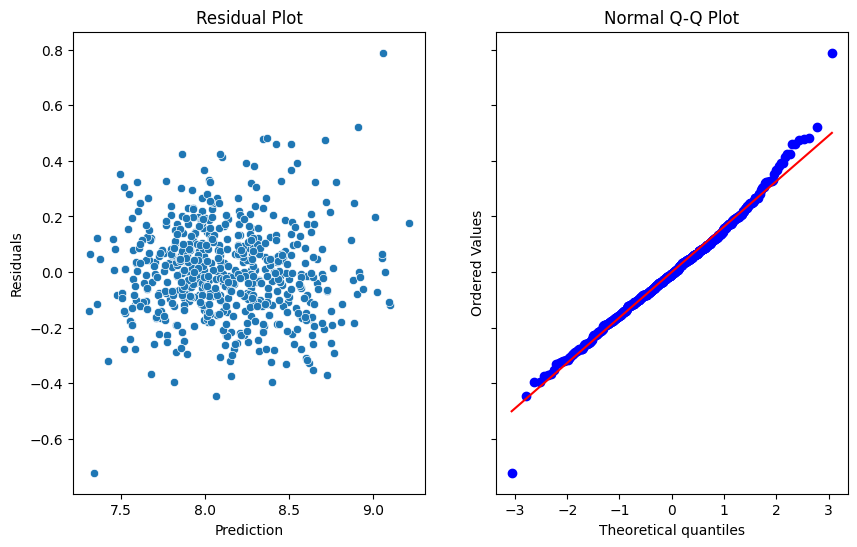

In [78]:
residual_analysis_plots(model)

In [79]:
# VIF Looks OK -- our parking dummy features are a bit high but no major concern

from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

pd.Series(
    [vif(X.values, i) for i in range(X.shape[1])],
    index=X.columns
)

const                        72.826674
sqft                         18.620191
beds                          9.043663
bath                          4.244758
sqft2                        12.879517
beds_bath_ratio               4.610907
laundry_not_in_unit           1.437557
pets_no_dogs                  1.100145
housing_type_single           1.201982
parking_(b) protected         7.676501
parking_(c) off-street        2.251142
parking_(d) no parking        8.343809
hood_district_central         1.387735
hood_district_marina          1.393107
hood_district_north beach     1.448326
hood_district_southwest       1.406537
hood_district_west            1.215979
dtype: float64

In [80]:
# Outliers
influence = model.get_influence()
inf_summary_df = influence.summary_frame()
inf_summary_df["cooks_d"].sort_values(ascending=False).head()

253    0.095761
602    0.043324
56     0.042658
863    0.029345
166    0.021223
Name: cooks_d, dtype: float64

In [81]:
# Finding the outlier
X.loc[253]

const                              1.0
sqft                            2358.0
beds                               3.0
bath                               3.0
sqft2                        5560164.0
beds_bath_ratio                    0.0
laundry_not_in_unit                0.0
pets_no_dogs                       1.0
housing_type_single                0.0
parking_(b) protected              0.0
parking_(c) off-street             0.0
parking_(d) no parking             0.0
hood_district_central              0.0
hood_district_marina               0.0
hood_district_north beach          0.0
hood_district_southwest            0.0
hood_district_west                 0.0
Name: 253, dtype: float64

In [82]:
# Because I used log.
np.exp(X.loc[253])

/home/tahar/.pyenv/versions/3.12.9/envs/proftg/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


const                         2.718282
sqft                               inf
beds                         20.085537
bath                         20.085537
sqft2                              inf
beds_bath_ratio               1.000000
laundry_not_in_unit           1.000000
pets_no_dogs                  2.718282
housing_type_single           1.000000
parking_(b) protected         1.000000
parking_(c) off-street        1.000000
parking_(d) no parking        1.000000
hood_district_central         1.000000
hood_district_marina          1.000000
hood_district_north beach     1.000000
hood_district_southwest       1.000000
hood_district_west            1.000000
Name: 253, dtype: float64

In [23]:
!git add regression_modelling_project.ipynb
!git commit -m "Feature Engineering"
!git push origin master

On branch master
Your branch is up to date with 'origin/master'.

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	.ipynb_checkpoints/
	SFAR_map.png
	regression_modelling_project-1.ipynb

nothing added to commit but untracked files present (use "git add" to track)
Everything up-to-date


## Final Model Fit

## final_model = sm.OLS(y, X).fit()

final_model.summary()

In [83]:
print(mae(np.exp(y_test), np.exp(final_model.predict(X_test)))) 
# print(f"Test MAE: {mae(y_test, model.predict(X_test))}") #468.13 if not transformed
print(f"Test R2: {r2(y_test, final_model.predict(X_test))}")

ValueError: shapes (198,17) and (14,) not aligned: 17 (dim 1) != 14 (dim 0)

In [84]:
!git add regression_modelling_project.ipynb
!git commit -m "Final Model Fit"
!git push origin master

On branch master
Your branch is up to date with 'origin/master'.

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	.ipynb_checkpoints/
	09_regularized_regression_project.ipynb
	09_regularized_regression_project.ipynb:Zone.Identifier
	09_regularized_regression_project_solution.ipynb
	09_regularized_regression_project_solution.ipynb:Zone.Identifier
	SFAR_map.png
	regression_modelling_project-1.ipynb

nothing added to commit but untracked files present (use "git add" to track)
Everything up-to-date


# Regularized Regression Project
Build a Ridge, Lasso, and ElasticNet models that predict the price column in the dataset on San Francisco Apartment rentals. Make sure to go through all the the relevant steps of the modelling workflow.

Use the model you built for the prior project as the basis for comparison. Does regularization improve fit?
Feel free to skip the EDA and checking of assumptions again
Engineer (or un-engineer previously) engineered Features as needed
Fit a Lasso, Ridge, and Elastic Net Regression using the features in your original model.
Once you are ready, fit your final model and report final model performance estimate by scoring on the test data. Report both test R-squared and MAE.
What happens to your error if you only model apartments <= 6000 in price... should we do this?
Advice:

Remember, regularization doesn't always help, but it can, especially if you let it choose features for you!


## Data Splitting

In [86]:
from sklearn.model_selection import train_test_split

target = "price"
drop_cols = [
#     "pets_no_dogs",
#     "housing_type_single"
]

X = sm.add_constant(eng_df.drop([target] + drop_cols, axis=1))

# Log transform slightly improves normality
y = np.log(eng_df[target])
# y = eng_df[target]

# Test Split
X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=2023)

## Scaling Data 

In [87]:
from sklearn.preprocessing import StandardScaler

std = StandardScaler()
X_tr = std.fit_transform(X.values)
X_te = std.transform(X_test.values)

## Ridge

In [88]:
from sklearn.linear_model import RidgeCV

n_alphas = 100
alphas = 10 ** np.linspace(-3, 3, n_alphas)

ridge_model = RidgeCV(alphas=alphas, cv=5)

ridge_model.fit(X_tr, y)
print(f"Cross Val R2: {ridge_model.score(X_tr, y)}")
print(f"Cross Val MAE: {mae(np.exp(y), np.exp(ridge_model.predict(X_tr)))}")
print(f"Alpha: {ridge_model.alpha_}")

Cross Val R2: 0.8245472089089847
Cross Val MAE: 467.6269604495327
Alpha: 0.6135907273413176


In [89]:
list(zip(X.columns, ridge_model.coef_))

[('const', 0.0),
 ('sqft', 0.35016009775981677),
 ('beds', 0.02859816449203895),
 ('bath', 0.05895532279249487),
 ('sqft2', -0.13949088074783092),
 ('beds_bath_ratio', 0.04514563478412533),
 ('laundry_not_in_unit', -0.04107572693217599),
 ('pets_no_dogs', -0.007715990314373172),
 ('housing_type_single', -0.0028830374125963657),
 ('parking_(b) protected', -0.08602652996697364),
 ('parking_(c) off-street', -0.03255164582409344),
 ('parking_(d) no parking', -0.11772963482533973),
 ('hood_district_central', 0.015554005993078225),
 ('hood_district_marina', 0.029164609112381282),
 ('hood_district_north beach', -0.005900079746705592),
 ('hood_district_southwest', -0.052040193814356844),
 ('hood_district_west', -0.010435344564377669)]

## Lasso

In [90]:
from sklearn.linear_model import LassoCV

n_alphas = 200
alphas = 10 ** np.linspace(-2, 3, n_alphas)

lasso_model = LassoCV(alphas=alphas, cv=5)

lasso_model.fit(X_tr, y)

print(f"Cross Val R2: {lasso_model.score(X_tr, y)}")
print(f"Cross Val MAE: {mae(np.exp(y), np.exp(lasso_model.predict(X_tr)))}")
print(f"Alpha: {lasso_model.alpha_}")

Cross Val R2: 0.8006880038808468
Cross Val MAE: 505.9973214171855
Alpha: 0.01


In [91]:
list(zip(X.columns, lasso_model.coef_))

[('const', 0.0),
 ('sqft', 0.20093358749200096),
 ('beds', 0.05954662155126757),
 ('bath', 0.0451956233210827),
 ('sqft2', -0.0),
 ('beds_bath_ratio', 0.03226921005172123),
 ('laundry_not_in_unit', -0.046019760763910934),
 ('pets_no_dogs', -9.612978191610704e-05),
 ('housing_type_single', -0.0),
 ('parking_(b) protected', -0.0),
 ('parking_(c) off-street', 0.0),
 ('parking_(d) no parking', -0.03370983350723003),
 ('hood_district_central', 1.1199057152105374e-05),
 ('hood_district_marina', 0.015801238459985437),
 ('hood_district_north beach', -0.006012962972578445),
 ('hood_district_southwest', -0.053067441687465515),
 ('hood_district_west', -0.004880625476335333)]

In [92]:
# print(mae(np.exp(y_test), np.exp(lasso_model.predict(X_te))))
# print(f"Test R2: {r2(y_test, lasso_model.predict(X_te))}")

## ENET

In [93]:
from sklearn.linear_model import ElasticNetCV

alphas = 10 ** np.linspace(-2, 3, 200)
l1_ratios = np.linspace(.01, 1, 100)

enet_model = ElasticNetCV(alphas=alphas, l1_ratio=l1_ratios, cv=5)

enet_model.fit(X_tr, y)

print(f"Cross Val R2: {enet_model.score(X_tr, y)}")
print(f"Cross Val MAE: {mae(np.exp(y), np.exp(enet_model.predict(X_tr)))}")
print(f"Alpha: {enet_model.alpha_}")
print(f"L1_Ratio: {enet_model.l1_ratio_}")

Cross Val R2: 0.8228002858126005
Cross Val MAE: 468.16888092813633
Alpha: 0.01
L1_Ratio: 0.01


## Final Model Test

In [94]:
print(f"Test MAE: {mae(np.exp(y_test), np.exp(ridge_model.predict(X_te)))}")
print(f"Test R2: {r2(y_test, ridge_model.predict(X_te))}")

Test MAE: 446.9198550531224
Test R2: 0.783046316826531


In [95]:
!git add regression_modelling_project.ipynb
!git commit -m "Regularized Regression Project"
!git push origin master

[master 3ac840d] Regularized Regression Project
 1 file changed, 369 insertions(+), 424 deletions(-)
Enumerating objects: 5, done.
Counting objects: 100% (5/5), done.
Delta compression using up to 22 threads
Compressing objects: 100% (3/3), done.
Writing objects: 100% (3/3), 67.76 KiB | 3.99 MiB/s, done.
Total 3 (delta 2), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (2/2), completed with 2 local objects.
To github.com:Proftg/SAN-FRANCISCO-RENT-PRICES.git
   eafa5b2..3ac840d  master -> master
